## Data preprocessing and cleaning

## Our goal of database is to define a style of each team in Premier League (English Top Football League) and then try to predict result of a match (Win-Draw-Lose) based on opponent and its playing style.

In [ ]:
# Import and load data
import pandas as pd

teams_stats_goals = pd.read_csv("TeamsPremierLeagueGoals.csv")
teams_stats = pd.read_csv("TeamsPremierLeague.csv")
matches = pd.read_csv("Matches.csv")

In [ ]:
# Check for missing values
print(matches.isnull().sum())
print(teams_stats_goals.isnull().sum())
print(teams_stats.isnull().sum())

# There are no missing values in the datasets and no outliers 

In [ ]:
# Drop columns that are not needed for analysis
teams_stats_goals = teams_stats_goals.drop(['Age','MP','Starts','Min','90s'],axis=1)
teams_stats = teams_stats.drop(['90s','Touches','Live','Succ','Tkld','PrgC','Mis','Dis','PrgR'],axis=1)
matches = matches.drop(['Day','Date','Day Date','Year Date','Venue','Referee'],axis=1)

In [ ]:
# Data preparation - matches dataset

# Rename columns for better readability
matches = matches.rename(columns={
                                    'Home': 'HomeTeam',
                                    'Away': 'AwayTeam',
                                    'xG Home': 'xG_Home',
                                    'xG Away': 'xG_Away',
                                    'Month Date':'Month',
                                    'Wk': 'Week'
                            })

# Set time into 3 zones: morning, afternoon, evening
def time_of_day(hour):
    if hour <= 12:
        return 'Morning'
    elif hour <= 18:
        return 'Afternoon'
    else:
        return 'Evening'
    
matches['Time'] = pd.to_datetime(matches['Time'], format='%H:%M').dt.hour
matches['Time'] = matches['Time'].apply(time_of_day)

print(matches)

In [ ]:
# Data preparation - teams_stats dataset 
print(teams_stats)

In [ ]:
# Split data frame into two: test_df and train_df 
# For classifier, we will use 2023 season as training data and 2024 season as test data
# For predictor, we will use 2023 season as training data and 2024 season as test data

#TODO: ATTENTION !!!! 
#TODO: PLEASE DO NOT USE TEST DATA FOR TRAINING THE MODEL
print(matches['Season'].dtype)
train_df = matches[matches['Season'] == 2023]
test_df = matches[matches['Season'] == 2024]

#print(train_df)

In [ ]:
print("Matches")
print(train_df.head())

print("teams Stats Goals")    
print(teams_stats_goals.head())

print("General Teams Stats")
print(teams_stats.head())

print(teams_stats_goals.columns)

Now we are checking correlation between xG with Goals  

In [ ]:

home_corr = train_df['xG_Home'].corr(train_df['Home_Score'])
away_corr = train_df['xG_Away'].corr(train_df['Away_Score'])

print(f"Correlation between xG Home and Home Score: {home_corr:.3f}")
print(f"Correlation between xG Away and Away Score: {away_corr:.3f}")


# as we can see based on results xG and Goals are slightly correlated

Before we checked for overall correlation of expected goals and actual goals

Now we want to see if there exists a correlation for each team individually - maybe some teams perform as expected, whereas others are unpredictable

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.scatterplot(data=teams_stats_goals, x='xG', y='Gls')
plt.plot([teams_stats_goals['xG'].min(), teams_stats_goals['xG'].max()],
         [teams_stats_goals['xG'].min(), teams_stats_goals['xG'].max()],
         color='red', linestyle='--')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Actual Goals (Goals)')
plt.title('xG vs Goals for Each Team')
plt.grid(True)
plt.show()

# each dot is one team, the red line is the reference line where actual goals are equal to expected goals
# we see that some teams deviate from the average but there are no important outliers

Now we want to check attendance's  influence on match

In [ ]:
average_attendance = train_df.groupby('HomeTeam')['Attendance'].mean()

# Define result for home team
def home_result(row):
    if row['Home_Score'] > row['Away_Score']:
        return 'Win'
    elif row['Home_Score'] == row['Away_Score']:
        return 'Draw'
    else:
        return 'Lose'

train_df['Home_Result'] = train_df.apply(home_result, axis=1)

# Compare attendance to the venue's average
train_df['Attendance_vs_Avg'] = train_df.apply(
    lambda row: 'More than avg' if row['Attendance'] > average_attendance[row['HomeTeam']] else 'Less than avg',
    axis=1
)

# Create a pivot table with counts
result_table = train_df.pivot_table(
    index='Home_Result',
    columns='Attendance_vs_Avg',
    aggfunc='size',
    fill_value=0
)

print(result_table)


In [ ]:
numeric_df = teams_stats[['Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd','Att Pen']]
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


correlations_ball_possesion = teams_stats[['Poss', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd','Att Pen']].corr().loc['Poss']
print(correlations_ball_possesion)


Teams with more possession tend to have more touches in the middle third. 

Teams with more possession have fewer touches in their defensive penalty area (because they are less often defending).

There is no strong relationship between possession and touches in defensive third.

Correlation between Def Pen and Def 3rd: Teams that have more touches in the defensive penalty area also tend to have more touches in the defensive third.

Correlation between Def Pen and Att 3rd: Teams that have more touches in their defensive penalty area slightly have fewer touches in the attacking third.

Correlation between Mid 3rd and Att 3rd: Teams that dominate the middle third also dominate the attacking third — strong positive link.

In [ ]:
combined_df = pd.merge(teams_stats_goals[['Squad', 'Gls']], 
                       teams_stats[['Squad', 'Att 3rd', 'Att Pen']],
                       on='Squad')

# Now calculate correlations
correlation_goals_touches = combined_df[['Gls', 'Att 3rd', 'Att Pen']].corr().loc['Gls']

print(correlation_goals_touches)

Those numbers prove that touches on opponent's half have impact on scored goals

              Squad                Style
0           Arsenal    High Press Attack
1       Aston Villa    Defensive Compact
2       Bournemouth  Possession Build-up
3         Brentford      Slow Possession
4          Brighton       Counter Attack
5           Burnley     Direct Long Ball
6           Chelsea       Counter Attack
7    Crystal Palace  Possession Build-up
8           Everton  Possession Build-up
9            Fulham     Direct Long Ball
10        Liverpool    High Press Attack
11       Luton Town  Possession Build-up
12  Manchester City    High Press Attack
13   Manchester Utd    Defensive Compact
14    Newcastle Utd    Defensive Compact
15  Nott'ham Forest  Possession Build-up
16    Sheffield Utd  Possession Build-up
17        Tottenham       Counter Attack
18         West Ham  Possession Build-up
19           Wolves     Direct Long Ball

Cluster Summary Stats:



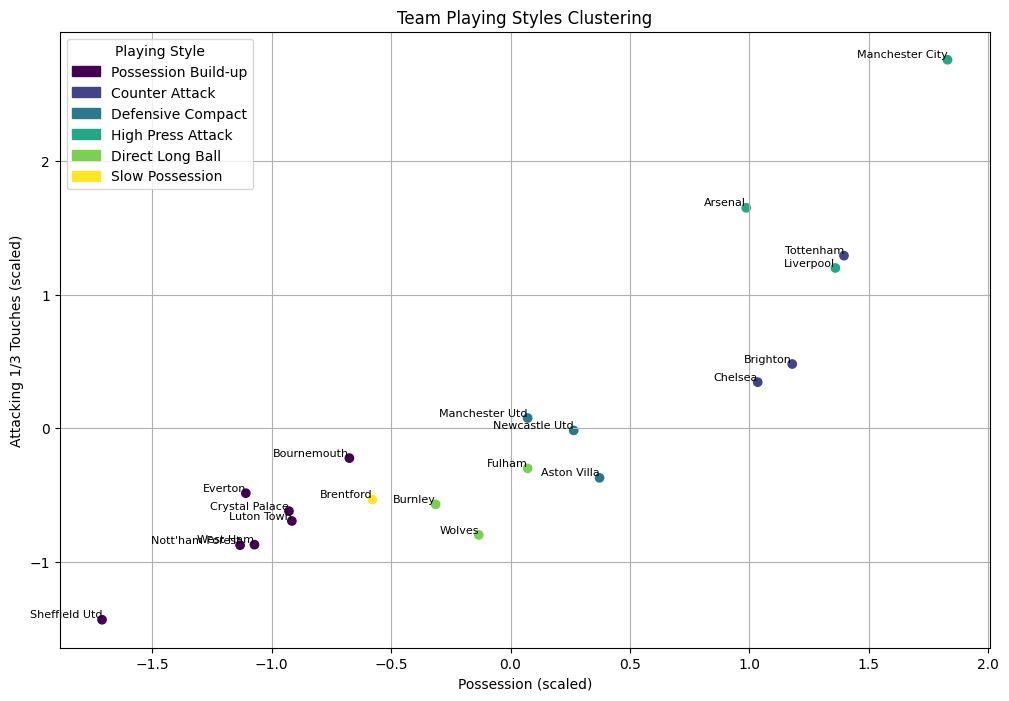

In [51]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Filter for Season 2024
teams_stats = teams_stats[teams_stats['Season'] == 2024]
teams_stats_goals = teams_stats_goals[teams_stats_goals['Season'] == 2024]

# Merge important features together
combined = pd.merge(
    teams_stats[['Squad', 'Poss', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Carries', 'TotDist', 'PrgDist', 'Rec']],
    teams_stats_goals[['Squad', 'Gls', 'Ast', 'xG', 'npxG', 'xAG', 'PrgP']],
    on='Squad'
)

# Features we care about
features = ['Poss', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 
            'Carries', 'TotDist', 'PrgDist', 'Rec', 
            'Gls', 'Ast', 'xG', 'npxG', 'xAG', 'PrgP']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined[features])

# Apply KMeans clustering (let's assume 6 clusters based on richer playing styles)
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
combined['Cluster'] = clusters

# Initial mapping of styles (to be adjusted after analyzing stats)
style_map = {
    0: 'Possession Build-up',
    1: 'Counter Attack',
    2: 'Defensive Compact',
    3: 'High Press Attack',
    4: 'Direct Long Ball',
    5: 'Slow Possession'
}

combined['Style'] = combined['Cluster'].map(style_map)

# Display the result
print(combined[['Squad', 'Style']])

# Summarize stats per cluster
cluster_summary = combined.groupby('Cluster')[features].mean().round(2)
print("\nCluster Summary Stats:\n")
#print(cluster_summary)


# Plot clusters for visualization 
plt.figure(figsize=(12,8))
scatter = plt.scatter(X_scaled[:,0], X_scaled[:,4], c=clusters, cmap='viridis')

# Team names on the plot
for i, team in enumerate(combined['Squad']):
    plt.text(X_scaled[i,0], X_scaled[i,4], team, fontsize=8, ha='right', va='bottom')

# Create legend manually
legend_labels = style_map
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=legend_labels[i]) for i in range(6)]
plt.legend(handles=handles, title="Playing Style")

plt.xlabel('Possession (scaled)')
plt.ylabel('Attacking 1/3 Touches (scaled)')
plt.title('Team Playing Styles Clustering')
plt.grid(True)
plt.show()


In [52]:
style_descriptions = pd.DataFrame({
    'Style': ['Possession Build-up', 'Counter Attack', 'Defensive Compact', 'High Press Attack', 'Direct Long Ball', 'Slow Possession'],
    'Description': [
        'Some teams (Man City, Brighton) dominate possession and build from the back.',
        'Some teams (Aston Villa, Wolves) focus on fast attacks after defense.',
        'Teams like Sheffield United, Luton stay very defensive, low possession.',
        'Teams like Liverpool or Arsenal press aggressively.',
        'Brentford, Everton: long balls, skipping midfield.',
        'Chelsea (bad form), Crystal Palace: slow passing without much attacking progress.'
    ]
})

print("\nStyle Descriptions:\n")
print(style_descriptions)


Style Descriptions:

                 Style                                        Description
0  Possession Build-up  Some teams (Man City, Brighton) dominate posse...
1       Counter Attack  Some teams (Aston Villa, Wolves) focus on fast...
2    Defensive Compact  Teams like Sheffield United, Luton stay very d...
3    High Press Attack  Teams like Liverpool or Arsenal press aggressi...
4     Direct Long Ball  Brentford, Everton: long balls, skipping midfi...
5      Slow Possession  Chelsea (bad form), Crystal Palace: slow passi...


In [54]:

team_styles_correct = dict(zip(combined['Squad'], combined['Style']))
# Map styles into matches
matches['Home_Style'] = matches['HomeTeam'].map(team_styles_correct)
matches['Away_Style'] = matches['AwayTeam'].map(team_styles_correct)

# Calculate Points for Home and Away teams
def get_points(home_goals, away_goals):
    if home_goals > away_goals:
        return (3, 0)
    elif home_goals == away_goals:
        return (1, 1)
    else:
        return (0, 3)

matches[['Home_Points', 'Away_Points']] = matches.apply(
    lambda row: pd.Series(get_points(row['Home_Score'], row['Away_Score'])),
    axis=1
)

# Prepare home and away results
home_results = matches[['HomeTeam', 'Away_Style', 'Home_Points']].rename(columns={
    'HomeTeam': 'Team',
    'Away_Style': 'Opponent_Style',
    'Home_Points': 'Points'
})
away_results = matches[['AwayTeam', 'Home_Style', 'Away_Points']].rename(columns={
    'AwayTeam': 'Team',
    'Home_Style': 'Opponent_Style',
    'Away_Points': 'Points'
})

# Combine
full_results = pd.concat([home_results, away_results])

# Group by Team and Opponent Style
performance = full_results.groupby(['Team', 'Opponent_Style']).agg(
    Matches=('Points', 'count'),
    Total_Points=('Points', 'sum')
).reset_index()

performance['Avg_Points'] = (performance['Total_Points'] / performance['Matches']).round(2)

# Find best and worst vs styles
best_vs = performance.loc[performance.groupby('Team')['Avg_Points'].idxmax()].reset_index(drop=True)
worst_vs = performance.loc[performance.groupby('Team')['Avg_Points'].idxmin()].reset_index(drop=True)

summary = best_vs[['Team', 'Opponent_Style', 'Avg_Points']].rename(columns={
    'Opponent_Style': 'Best_vs_Style',
    'Avg_Points': 'Best_Avg_Points'
})
summary['Worst_vs_Style'] = worst_vs['Opponent_Style']
summary['Worst_Avg_Points'] = worst_vs['Avg_Points']

print(summary)

               Team        Best_vs_Style  Best_Avg_Points     Worst_vs_Style  \
0           Arsenal  Possession Build-up             2.58  High Press Attack   
1       Aston Villa     Direct Long Ball             2.00  Defensive Compact   
2       Bournemouth     Direct Long Ball             2.00  High Press Attack   
3         Brentford  Possession Build-up             1.64  Defensive Compact   
4          Brighton  Possession Build-up             1.72  High Press Attack   
5           Burnley      Slow Possession             1.50  High Press Attack   
6           Chelsea  Possession Build-up             2.22  High Press Attack   
7    Crystal Palace     Direct Long Ball             1.91     Counter Attack   
8           Everton      Slow Possession             2.50  Defensive Compact   
9            Fulham  Possession Build-up             1.84  High Press Attack   
10     Leeds United     Direct Long Ball             1.50  High Press Attack   
11   Leicester City     Direct Long Ball

In [ ]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Label: Home result (Win = 1, Draw = 0, Loss = -1)
def result_label(home_goals, away_goals):
    if home_goals > away_goals:
        return 1
    elif home_goals == away_goals:
        return 0
    else:
        return -1

matches['Result_Label'] = matches.apply(lambda row: result_label(row['Home_Score'], row['Away_Score']), axis=1)
print(matches['Result_Label'].value_counts())

style_encoder = LabelEncoder()
matches['Home_Style_Enc'] = style_encoder.fit_transform(matches['Home_Style'])
matches['Away_Style_Enc'] = style_encoder.transform(matches['Away_Style'])


# Split data into training and testing sets (look up, it was done before)
train_df = matches[matches['Season'] == 2023]
test_df = matches[matches['Season'] == 2024]

X_train = train_df[['Home_Style_Enc', 'Away_Style_Enc']]
y_train = train_df['Result_Label']

X_test = test_df[['Home_Style_Enc', 'Away_Style_Enc']]
y_test = test_df['Result_Label']




Result_Label
 1    376
-1    248
 0    173
Name: count, dtype: int64


In [ ]:
# Build and train the decison tree classifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# How to interpert the confusion matrix:
# Frist row: correctly classifies losses (0), draws classified as losses(1), wins classied as losses (2)
# now our model is coorect 53% for losses, 27% for draws and 60% for wins

              precision    recall  f1-score   support

          -1       0.53      0.58      0.55       139
           0       0.27      0.14      0.18        86
           1       0.60      0.69      0.64       192

    accuracy                           0.54       417
   macro avg       0.47      0.47      0.46       417
weighted avg       0.51      0.54      0.52       417

[[ 81  15  43]
 [ 30  12  44]
 [ 43  17 132]]


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the decision tree

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=['Home_Style_Enc', 'Away_Style_Enc'], class_names=['Loss', 'Draw', 'Win'], filled=True)
plt.show()

We see that right now our model is not very good. It classifies corrrectly: losses 53%, draws 27% and wins 60% of the time. 

We must ask WHY our model is so bad at predicting draws. Maybe we need more features, maybe some additional calculations should be introduced.

Before changing datasets, lets check different models:
1. Random Forest Classifier
2. Gradient Boosting Classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)

print("=== Random Forest Classifier ===")
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))


=== Random Forest Classifier ===
              precision    recall  f1-score   support

          -1       0.58      0.50      0.54       139
           0       0.25      0.09      0.14        86
           1       0.57      0.79      0.66       192

    accuracy                           0.55       417
   macro avg       0.47      0.46      0.44       417
weighted avg       0.51      0.55      0.51       417

[[ 69   9  61]
 [ 24   8  54]
 [ 25  15 152]]


In [68]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

gb_preds = gb_model.predict(X_test)

print("=== Gradient Boosting Classifier ===")
print(classification_report(y_test, gb_preds))
print(confusion_matrix(y_test, gb_preds))

=== Gradient Boosting Classifier ===
              precision    recall  f1-score   support

          -1       0.54      0.45      0.49       139
           0       0.33      0.06      0.10        86
           1       0.54      0.81      0.65       192

    accuracy                           0.53       417
   macro avg       0.47      0.44      0.41       417
weighted avg       0.50      0.53      0.48       417

[[ 62   6  71]
 [ 21   5  60]
 [ 32   4 156]]


We see that with different models the performance is even worse. It gives us a thought that the problem lays with the data that we take into account.
Let's go back to Decision trees, we want to use k-fold to cross-validate our model and see if we can reduce over/under-fitting that might be causing such low performence

In [ ]:
#TODO: add more columns with some different metrics, combine dataset into one
# maybe merging all columns before wasnt so good, and instead we should make more columns? 